In [1]:
# default_exp pixelcnn

In [2]:
#hide
%load_ext autoreload
%autoreload 2

# PixelCNN model

## Layers

In [3]:
# export
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from typing import Sequence, Union, Tuple

from generative_models.layers import exist, scale, unscale, ChanLayerNorm

In [4]:
# hide
import matplotlib.pyplot as plt

In [5]:
# export
class MaskedConv2d(nn.Module):
    def __init__(self, c_in, c_out, ks, mask, stride=1, padding=None, d_cond:int=None):
        super().__init__()
        if padding is None: padding = (ks-1)//2
        self.stride, self.padding = stride, padding
        self.weight = nn.Parameter(torch.randn(c_out, c_in, ks, ks))
        self.bias = nn.Parameter(torch.zeros(c_out))
        self.register_buffer('mask', mask[None, None])
        nn.init.kaiming_normal_(self.weight)
        if d_cond is not None:
            self.cond_proj = nn.Linear(d_cond, c_out)
        else:
            self.cond_proj = None

    def forward(self, x, cond=None):
        out = F.conv2d(x, self.weight*self.mask, self.bias, self.stride, self.padding)
        if exist(self.cond_proj) and exist(cond):
            out += self.cond_proj(cond)[..., None, None]
        return out

In [6]:
# export
def make_mask_a(ks:int):
    n = ks*ks
    mask = torch.arange(n).reshape(ks,ks)
    mask = (mask < n//2).float()
    return mask

def make_mask_b(ks:int):
    n = ks*ks
    mask = torch.arange(n).reshape(ks,ks)
    mask = (mask <= n//2).float()
    return mask


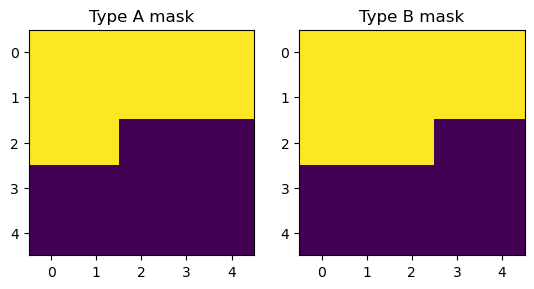

In [7]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(make_mask_a(5).numpy())
axs[0].set_title("Type A mask")
axs[1].imshow(make_mask_b(5).numpy())
axs[1].set_title("Type B mask")
plt.show()

In [8]:
# export
class SimplePixelCNN(nn.Module):
    "Simple PixelCNN"
    def __init__(self, nh:int=64, ks:int=7, n_layers:int=8, d_cond:int=None, size=20):
        super().__init__()
        layers = []
        layers += [MaskedConv2d(1, nh, ks, make_mask_a(ks), d_cond=d_cond), ChanLayerNorm(nh), nn.ReLU()]
        for _ in range(n_layers-3):
            layers += [MaskedConv2d(nh,nh, ks, make_mask_b(ks), d_cond=d_cond), ChanLayerNorm(nh), nn.ReLU()]
        layers += [nn.Conv2d(nh, nh//2, 1), nn.ReLU()]
        layers += [nn.Conv2d(nh//2, 1,  1)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, cond=None):
        for l in self.layers:
            if isinstance(l, MaskedConv2d):
                x = l(x, cond)
            else:
                x = l(x)
        return x

    def sample(self, d:int, n:int=16, cond=None):
        
        if exist(cond):
            if cond.size(0) != n:
                print(f"Number of provided conditional inputs ({cond.size(0)}) should match number of samples ({n})!")
                n = cond.size(0)
        
        x = torch.ones(n,1,d,d)
        for i in range(d):
            for j in range(d):
                out = self(x, cond)
                x[:, :, i, j] = scale((torch.sigmoid(out[:, :, i, j]) > torch.rand(x.size(0),1)).float())
        return unscale(x)

In [12]:
x = torch.randn(4,1,8,8)
model = SimplePixelCNN()
out = model(x)
assert out.shape == x.shape

In [14]:
# slow
res = model.sample(n=4, d=8)
assert res.shape == (4,1,8,8)

In [15]:
# hide
c = torch.rand(10)
x = torch.randn(4,1,8,8)
model = SimplePixelCNN(d_cond=10)
out = model(x, c)
assert out.shape == x.shape

In [13]:
# export
class PixelCNNResBlock(nn.Module):

    def __init__(self, c_in, c_out, ks, mask, stride=1, padding=None, d_cond:int=None) -> None:
        super().__init__()
        h = c_out // 2
        self.net = nn.ModuleList([
            nn.Conv2d(c_in, h, 1),
            nn.ReLU(),
            MaskedConv2d(h, h, ks, mask, stride, padding, d_cond),
            nn.ReLU(),
            nn.Conv2d(h, c_out, 1)
        ])
        self.norm = ChanLayerNorm(c_in)
        
    def forward(self, x, cond=None):
        x = self.norm(x)
        res = x
        for l in self.net:
            if isinstance(l, MaskedConv2d):
                res = l(res, cond)
            else:
                res = l(res)
        return x + res

In [14]:
x = torch.randn(4,16,8,8)
m = PixelCNNResBlock(16, 16, 5, make_mask_b(5))
out = m(x)
assert out.shape == x.shape

In [15]:
# export
class PixelCNN(nn.Module):
    "PixelCNN"
    def __init__(self, nh:int=64, ks:int=7, n_layers:int=8, d_cond:int=None, size=20):
        super().__init__()
        layers = [MaskedConv2d(1, nh, ks, make_mask_a(ks), d_cond=d_cond), ChanLayerNorm(nh), nn.ReLU()]
        for _ in range(n_layers-3):
            layers += [PixelCNNResBlock(nh,nh, ks, make_mask_b(ks), d_cond=d_cond)]
        layers += [nn.Conv2d(nh, nh//2, 1), nn.ReLU()]
        layers += [nn.Conv2d(nh//2, 1,  1)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, cond=None):
        for l in self.layers:
            if isinstance(l, MaskedConv2d):
                x = l(x, cond)
            else:
                x = l(x)
        return x

    def sample(self, d:int, n:int=16, cond=None):
        
        if exist(cond):
            if cond.size(0) != n:
                print(f"Number of provided conditional inputs ({cond.size(0)}) should match number of samples ({n})!")
                n = cond.size(0)
        
        x = torch.ones(n,1,d,d)
        for i in range(d):
            for j in range(d):
                out = self(x, cond)
                x[:, :, i, j] = scale((torch.sigmoid(out[:, :, i, j]) > torch.rand(x.size(0),1)).float())
        return unscale(x)

In [16]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_layers.ipynb.
Converted 01_training.ipynb.
Converted 02_made.ipynb.
Converted 03_pixelcnn.ipynb.
Converted 04_vae.ipynb.
Converted 10_experiments.pixelcnn.ipynb.
Converted index.ipynb.
